In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings


In [3]:
df = pd.read_csv("./data/Pivot_rideshare_with_missing.csv")


In [4]:
df = df[["Location", "Provider", "Service_Type", "Timestamp", "price_max", "price_mean", "price_min"]]
df

,Location,Provider,Service_Type,Timestamp,price_max,price_mean,price_min
0,Back Bay,Lyft,Lux,2018-11-26 06:00:00+00:00,22.5,16.555556,11.0
1,Back Bay,Lyft,Lux,2018-11-26 07:00:00+00:00,27.5,17.300000,13.5
2,Back Bay,Lyft,Lux,2018-11-26 08:00:00+00:00,13.5,13.500000,13.5
3,Back Bay,Lyft,Lux,2018-11-26 09:00:00+00:00,32.5,17.954545,13.5
4,Back Bay,Lyft,Lux,2018-11-26 10:00:00+00:00,26.0,18.625000,13.5
...,...,...,...,...,...,...,...
84391,West End,Uber,WAV,2018-12-18 14:00:00+00:00,19.0,9.852941,6.5
84392,West End,Uber,WAV,2018-12-18 15:00:00+00:00,11.0,8.933333,7.0
84393,West End,Uber,WAV,2018-12-18 16:00:00+00:00,16.5,9.733333,7.5
84394,West End,Uber,WAV,2018-12-18 17:00:00+00:00,13.0,10.222222,7.0


In [5]:
df["Location"].value_counts()

Location
Back Bay                   7033
Beacon Hill                7033
Boston University          7033
Fenway                     7033
Financial District         7033
Haymarket Square           7033
North End                  7033
North Station              7033
Northeastern University    7033
South Station              7033
Theatre District           7033
West End                   7033
Name: count, dtype: int64

In [6]:
df["Provider"].value_counts()

Provider
Uber    45444
Lyft    38952
Name: count, dtype: int64

In [7]:
df["Service_Type"].value_counts()

Service_Type
Lux             6492
Lux Black       6492
Lux Black XL    6492
Lyft            6492
Lyft XL         6492
Shared          6492
Black           6492
Black SUV       6492
Taxi            6492
UberPool        6492
UberX           6492
UberXL          6492
WAV             6492
Name: count, dtype: int64

In [8]:
# 기본키에 해당하는 칼럼만 선택한 후, 중복 제거하여 고유한 조합을 구함
unique_keys = df[['Location', 'Provider', 'Service_Type']].drop_duplicates()
print("총 PK 개수:", unique_keys.shape[0])


총 PK 개수: 156


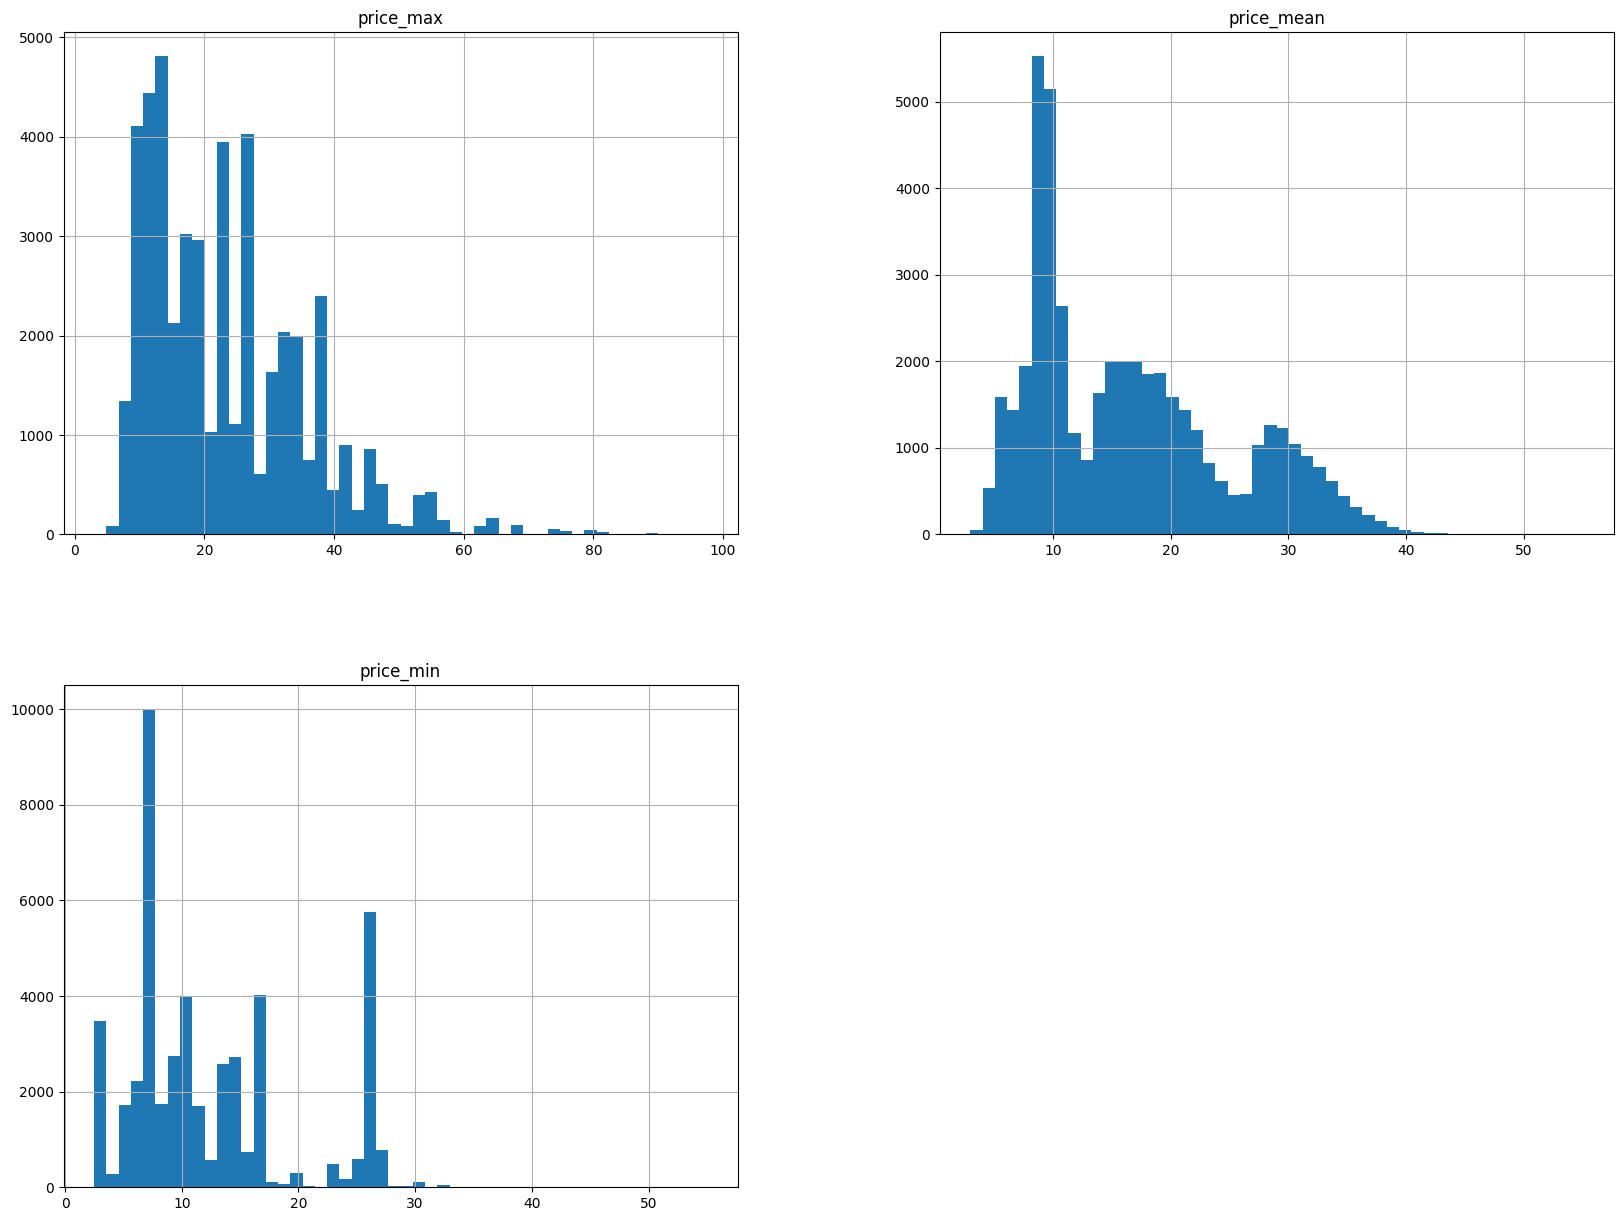

In [9]:
df.hist(bins=50, figsize=(20,15))
plt.show()

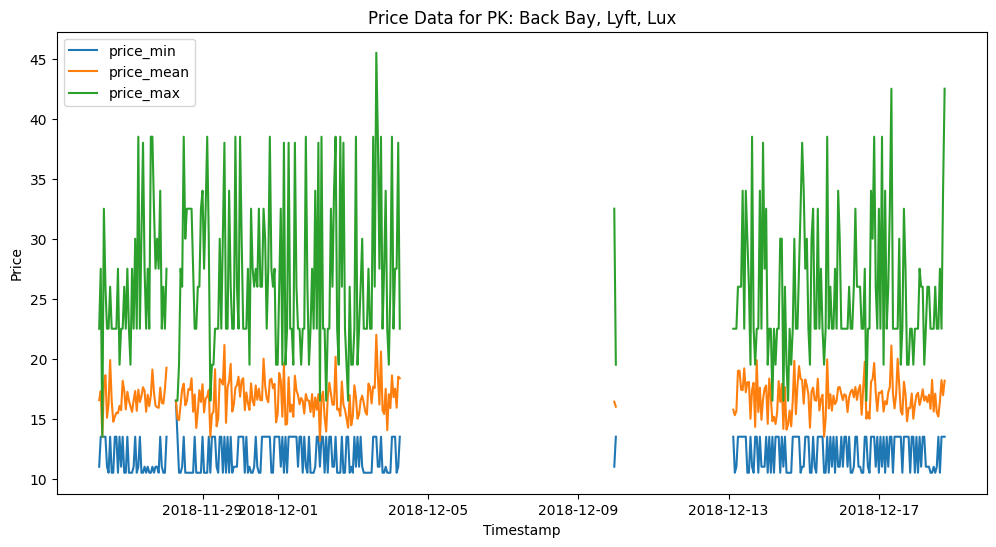

In [10]:
# Timestamp 칼럼을 datetime 형식으로 변환하고 정렬
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.sort_values('Timestamp', inplace=True)

# 고유 PK 조합 (Location, Provider, Service_Type) 중 첫 번째를 선택
unique_pk = df[['Location', 'Provider', 'Service_Type']].drop_duplicates().iloc[0]
selected_location = unique_pk['Location']
selected_provider = unique_pk['Provider']
selected_service_type = unique_pk['Service_Type']

# 해당 PK 조합의 데이터 필터링
filtered_df = df[(df['Location'] == selected_location) &
                 (df['Provider'] == selected_provider) &
                 (df['Service_Type'] == selected_service_type)]

# 시각화: Timestamp를 x축으로, price_min, price_mean, price_max를 플롯
plt.figure(figsize=(12, 6))
plt.plot(filtered_df['Timestamp'], filtered_df['price_min'], linestyle='-', label='price_min')
plt.plot(filtered_df['Timestamp'], filtered_df['price_mean'], linestyle='-', label='price_mean')
plt.plot(filtered_df['Timestamp'], filtered_df['price_max'], linestyle='-', label='price_max')
plt.xlabel("Timestamp")
plt.ylabel("Price")
plt.title(f"Price Data for PK: {selected_location}, {selected_provider}, {selected_service_type}")
plt.legend()
plt.show()


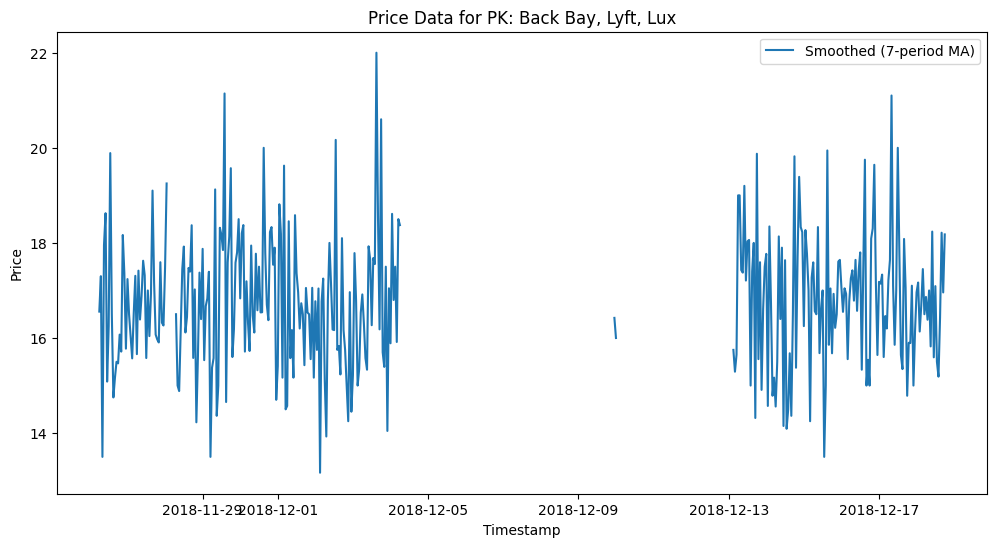

In [11]:
# Timestamp 칼럼을 datetime 형식으로 변환하고 정렬
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.sort_values('Timestamp', inplace=True)

# 고유 PK 조합 (Location, Provider, Service_Type) 중 첫 번째 조합 선택
unique_pk = df[['Location', 'Provider', 'Service_Type']].drop_duplicates().iloc[0]
selected_location = unique_pk['Location']
selected_provider = unique_pk['Provider']
selected_service_type = unique_pk['Service_Type']

# 해당 PK 조합의 데이터 필터링
filtered_df = df[(df['Location'] == selected_location) &
                 (df['Provider'] == selected_provider) &
                 (df['Service_Type'] == selected_service_type)]

# 원본 데이터를 복사 후, 이동평균을 이용해 'price_min' 칼럼 smoothing (7기간)
filtered_df = filtered_df.copy()
filtered_df['price_min_smoothed'] = filtered_df['price_mean'].rolling(window=1, center=True).mean()

# 시각화: 원본과 smoothing된 price_min 플롯
plt.figure(figsize=(12, 6))
plt.plot(filtered_df['Timestamp'], filtered_df['price_min_smoothed'], linestyle='-',
         label='Smoothed (7-period MA)')
plt.xlabel("Timestamp")
plt.ylabel("Price")
plt.title(f"Price Data for PK: {selected_location}, {selected_provider}, {selected_service_type}")
plt.legend()
plt.show()


In [12]:
# df: pk와 price 관련 컬럼만 포함한 DataFrame
# price 관련 컬럼 이름을 필요에 따라 수정하세요.
price_cols = ['price_min', 'price_mean', 'price_max']

# pk 그룹별로 최소 하나의 유효한 값이 있는 그룹만 남김
df_clean = df.groupby(['Location', 'Provider', 'Service_Type']).filter(
    lambda group: group[price_cols].notna().sum().sum() > 0
)

print("결측치만 있는 pk가 제거된 후 데이터 shape:", df_clean.shape)

# 원래의 pk 개수 확인
original_pk_count = df[['Location', 'Provider', 'Service_Type']].drop_duplicates().shape[0]
print("원래의 PK 개수:", original_pk_count)

# df_clean은 이미 결측치만 있는 pk를 제거한 DataFrame입니다.
cleaned_pk_count = df_clean[['Location', 'Provider', 'Service_Type']].drop_duplicates().shape[0]
print("결측치 제거 후의 PK 개수:", cleaned_pk_count)
df = df_clean
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)
df.sort_index(inplace=True)

결측치만 있는 pk가 제거된 후 데이터 shape: (77904, 7)
원래의 PK 개수: 156
결측치 제거 후의 PK 개수: 144


In [13]:
# 각 Timestamp에 대해 모든 PK의 "price_mean"이 결측인지 확인
# (Timestamp에 해당하는 모든 행에서 price_mean이 NaN이면 True, 아니면 False)
common_missing = df.groupby(df.index)['price_mean'].apply(lambda x: x.isna().all())

# 이제 common_missing은 unique한 Timestamp 인덱스를 가진 Series입니다.
# True인 Timestamp들이 모든 PK에서 결측인 시간입니다.
mask = common_missing  # boolean Series: True if all PK missing at that timestamp

# 연속된 구간을 구분하기 위해 그룹 번호를 생성합니다.
group_id = (mask != mask.shift()).cumsum()

# 결측값(True)인 경우만 필터링한 후, 그룹별로 묶습니다.
missing_groups = common_missing[mask].groupby(group_id)

# 각 그룹별로 시작시간, 종료시간, 결측 데이터 개수를 출력합니다.
for _, group in missing_groups:
    if group.empty:
        continue
    start_time = group.index[0]
    end_time = group.index[-1]
    count = len(group)
    print(f"{start_time} ~ {end_time}, {count}개 데이터 결측")


2018-11-28 02:00:00+00:00 ~ 2018-11-28 06:00:00+00:00, 5개 데이터 결측
2018-12-04 07:00:00+00:00 ~ 2018-12-09 22:00:00+00:00, 136개 데이터 결측
2018-12-10 03:00:00+00:00 ~ 2018-12-13 02:00:00+00:00, 72개 데이터 결측


In [14]:
import warnings
import os
import pandas as pd
import numpy as np

# DeprecationWarning 무시
warnings.filterwarnings("ignore", category=DeprecationWarning)

# 1. 데이터 불러오기 및 초기 전처리
df = pd.read_csv("./data/Pivot_rideshare_with_missing.csv")
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.sort_values('Timestamp', inplace=True)
df.set_index('Timestamp', inplace=True)

# 2. price 관련 컬럼이 전혀 없는 PK 제거
price_cols = ['price_min', 'price_mean', 'price_max']
df = df.groupby(['Location', 'Provider', 'Service_Type']).filter(
    lambda group: group[price_cols].notna().sum().sum() > 0
)

# 3. 각 그룹별 merged 결측 구간 처리 함수
def merge_missing_segments(group, pk, merge_threshold=10):
    # 반드시 시간 순으로 정렬 (index 기준)
    group = group.sort_index()
    target_cols = ['price_min', 'price_mean', 'price_max']
    
    for col in target_cols:
        series = group[col].copy()
        # 현재 NaN이면 True, 값이 있으면 False
        missing_mask = series.isna().to_numpy()
        n = len(missing_mask)
        i = 0
        while i < n:
            if not missing_mask[i]:
                start = i
                # 연속된 non-missing 구간 찾기
                while i < n and not missing_mask[i]:
                    i += 1
                end = i - 1
                gap_length = end - start + 1
                # 양쪽이 모두 NaN으로 둘러싸여 있는 경우 (경계면 제외)
                if start > 0 and i < n and missing_mask[start-1] and missing_mask[i]:
                    if gap_length < merge_threshold:
                        # 이 구간의 값을 NaN으로 만듦
                        missing_mask[start:i] = True
            else:
                i += 1
        # 새 mask를 반영하여 series 업데이트
        new_series = series.copy()
        new_series[missing_mask] = np.nan
        group[col] = new_series
    return group

# 4. 전체 데이터에 대해 PK별 merged 결측 구간 처리 적용
pk_cols = ['Location', 'Provider', 'Service_Type']
df_merged = df.groupby(pk_cols, group_keys=False)\
              .apply(lambda group: merge_missing_segments(group, group.name, merge_threshold=10))

# 5. PK별 CSV 저장을 위한 폴더 생성 및 저장
output_folder = "./pk_csv_files"
os.makedirs(output_folder, exist_ok=True)

for pk, group in df_merged.groupby(pk_cols):
    filename = f"{pk[0]}_{pk[1]}_{pk[2]}.csv"
    filepath = os.path.join(output_folder, filename)
    group.to_csv(filepath)

# 6. 모든 PK들이 공유하는 결측 구간 출력 (price_mean 기준)
common_missing = df_merged.groupby(df_merged.index)['price_mean'].apply(lambda x: x.isna().all())
timestamps = common_missing.index
vals = common_missing.values

common_segments = []
in_seg = False
start_idx = None
for i, v in enumerate(vals):
    if v and not in_seg:
        in_seg = True
        start_idx = i
    elif not v and in_seg:
        common_segments.append((start_idx, i - 1))
        in_seg = False
if in_seg:
    common_segments.append((start_idx, len(vals) - 1))

print("모든 PK들이 공유하는 결측 구간:")
for seg in common_segments:
    seg_start = timestamps[seg[0]]
    seg_end = timestamps[seg[1]]
    count = seg[1] - seg[0] + 1
    print(f"  {seg_start} ~ {seg_end} ({count} timestamps)")


모든 PK들이 공유하는 결측 구간:
  2018-11-28 02:00:00+00:00 ~ 2018-11-28 06:00:00+00:00 (5 timestamps)
  2018-12-04 07:00:00+00:00 ~ 2018-12-13 02:00:00+00:00 (212 timestamps)


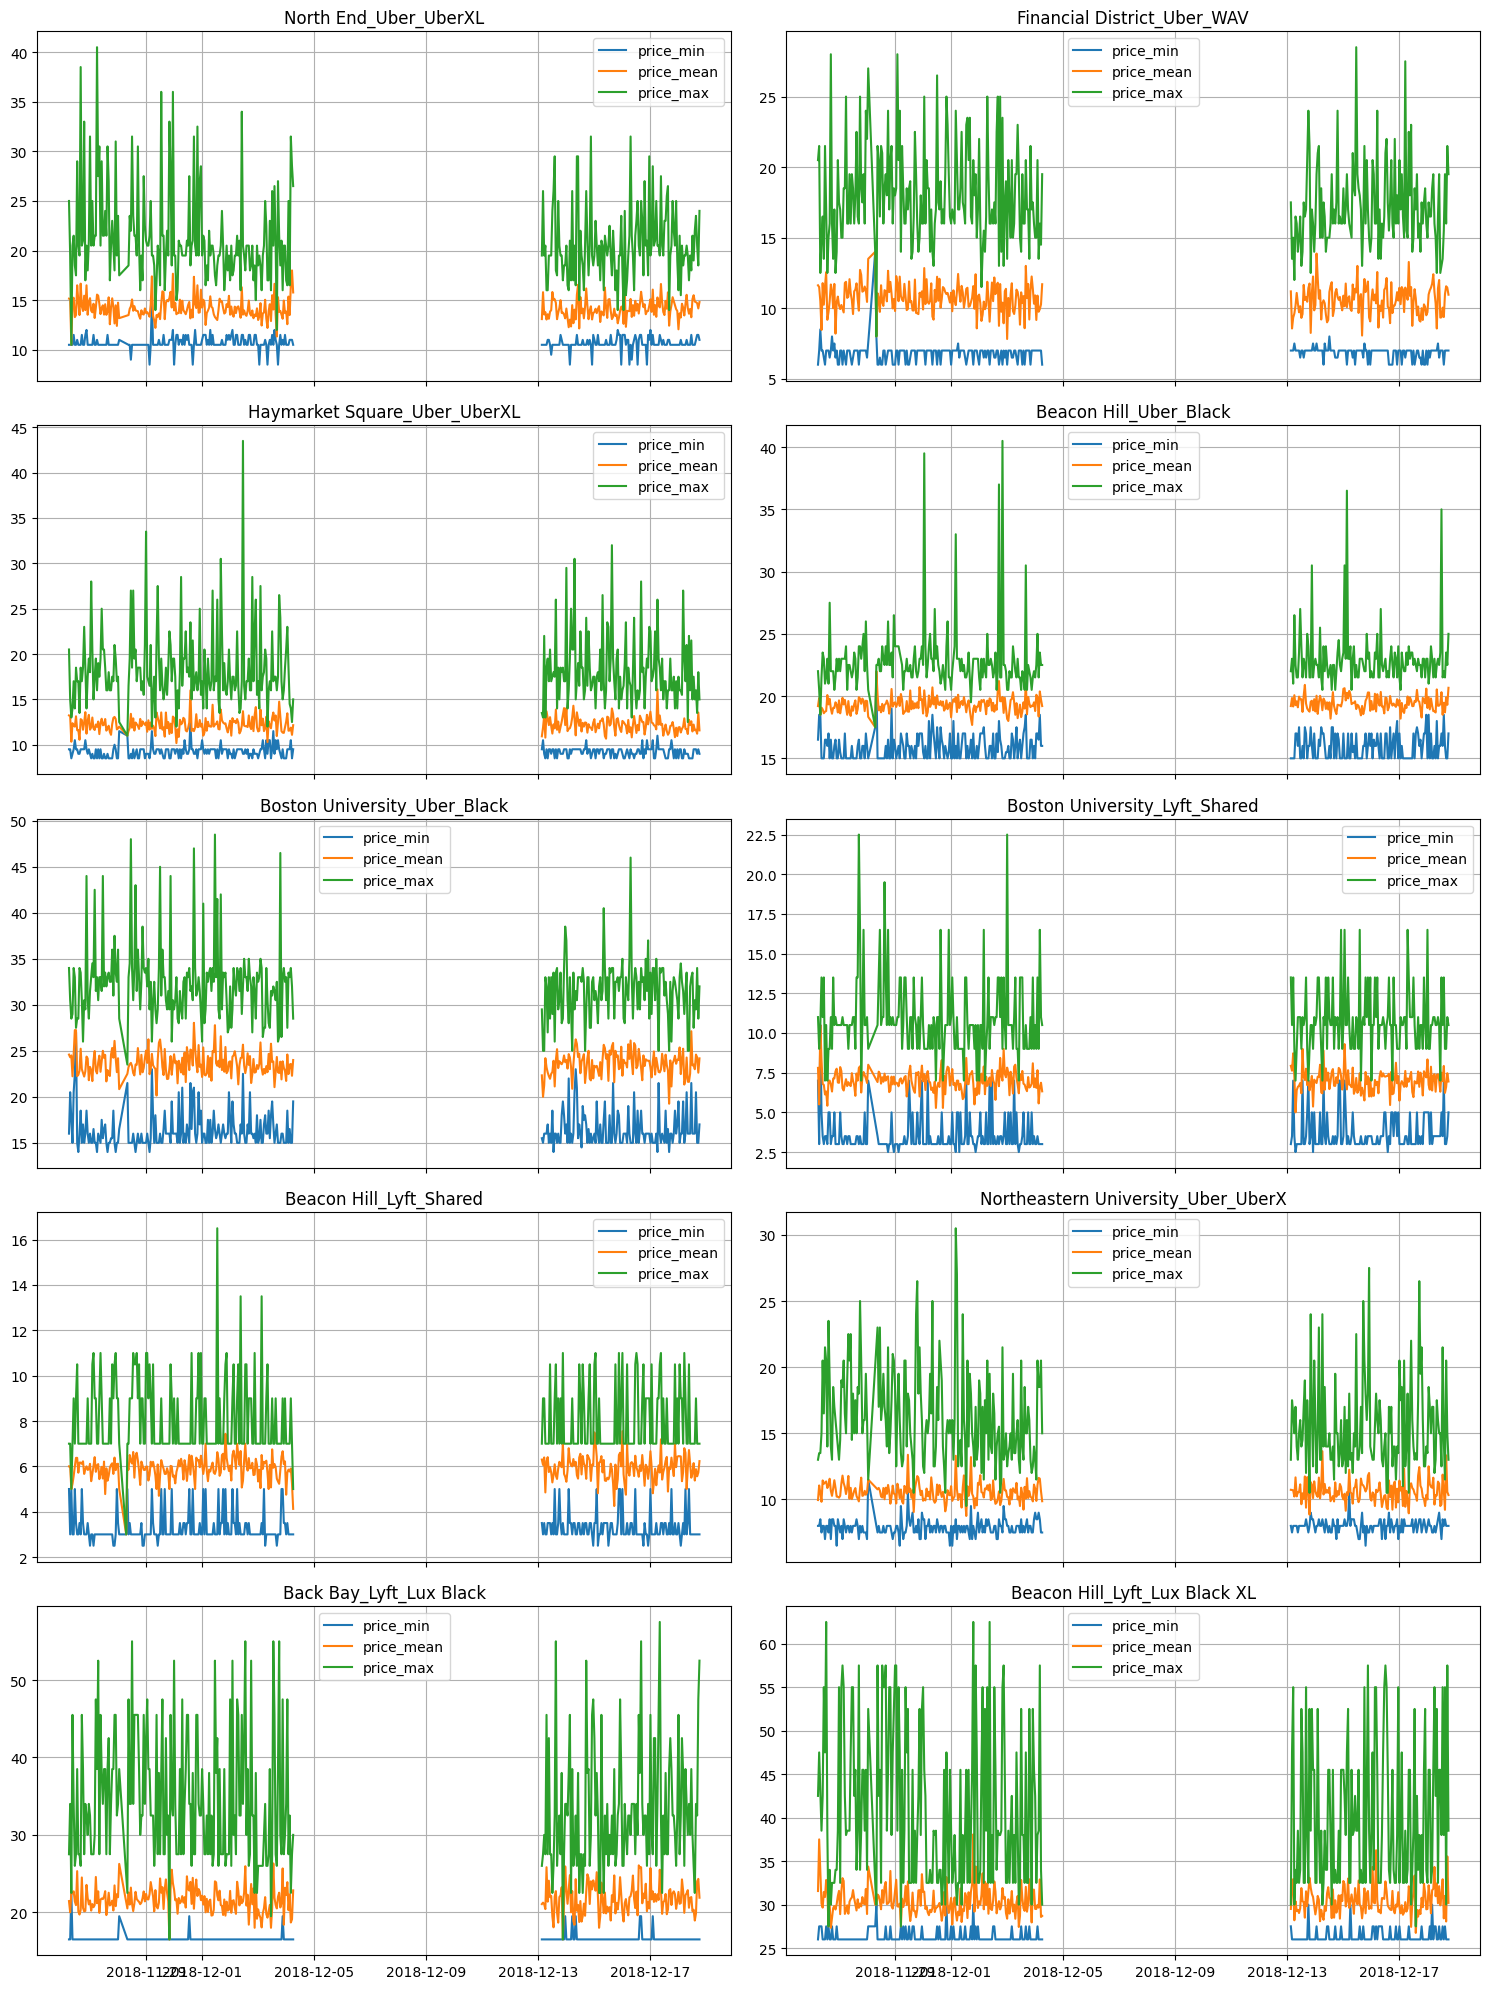

In [15]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

# 보간에서 제외할 구간 정의
forbid_start = pd.Timestamp("2018-12-04 07:00:00+00:00")
forbid_end   = pd.Timestamp("2018-12-13 02:00:00+00:00")

# CSV 파일들이 저장된 폴더
folder = "./pk_csv_files"
file_list = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(".csv")]

# 보간 처리된 결과를 저장할 폴더 생성
output_folder = "./pk_imput_files"
os.makedirs(output_folder, exist_ok=True)

# 각 CSV 파일을 불러와 보간 처리한 결과를 저장할 dict
imputed_dfs = {}

for file in file_list:
    df = pd.read_csv(file, index_col=0)
    # 인덱스를 datetime (타임존 포함)으로 변환
    df.index = pd.to_datetime(df.index, utc=True)
    
    # 보간 대상 칼럼: price_min, price_mean, price_max
    target_cols = ['price_min', 'price_mean', 'price_max']
    
    # 보간 제외 구간의 원본 데이터를 저장 (해당 구간은 보간하면 안됨)
    forbid_mask = (df.index >= forbid_start) & (df.index <= forbid_end)
    original_forbid = df.loc[forbid_mask, target_cols].copy()
    
    # 전체 DataFrame에 대해 linear interpolation 적용 (보간 대상 칼럼만)
    df[target_cols] = df[target_cols].interpolate(method='linear')
    
    # 보간 제외 구간은 원본 값으로 복원
    df.loc[forbid_mask, target_cols] = original_forbid
    
    # 결과를 딕셔너리에 저장
    imputed_dfs[file] = df
    
    # 보간 처리된 DataFrame을 output 폴더에 저장
    base_name = os.path.basename(file)
    output_path = os.path.join(output_folder, base_name)
    df.to_csv(output_path)

# 임의의 10개 PK 파일 선택 후 서브플롯 시각화
sample_files = random.sample(list(imputed_dfs.keys()), 10)

fig, axes = plt.subplots(5, 2, figsize=(15, 20), sharex=True)
axes = axes.flatten()

for ax, file in zip(axes, sample_files):
    df = imputed_dfs[file]
    ax.plot(df.index, df['price_min'], label='price_min')
    ax.plot(df.index, df['price_mean'], label='price_mean')
    ax.plot(df.index, df['price_max'], label='price_max')
    title = os.path.basename(file).replace(".csv", "")
    ax.set_title(title)
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


In [2]:
import pandas as pd

# CSV 파일 불러오기
df = pd.read_csv("./pk_imput_files/Back Bay_Lyft_Lux Black XL.csv")

# Timestamp를 datetime 타입으로 변환
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# 결측 구간: 행 인덱스 193과 404에 해당하는 Timestamp 값 추출
df = df[:193]
df

,Timestamp,Location,Provider,Service_Type,api_calls,clouds,distance_max,distance_mean,distance_min,humidity,price_max,price_mean,price_min,rain,surge_max,surge_mean,surge_min,temp,wind
0,2018-11-26 06:00:00+00:00,Back Bay,Lyft,Lux Black XL,11.0,0.990667,3.03,1.885455,1.06,0.913333,52.5,33.454545,26.0,0.0,2.00,1.090909,1.0,40.627333,1.350667
1,2018-11-26 07:00:00+00:00,Back Bay,Lyft,Lux Black XL,7.0,0.970000,2.30,1.450000,1.06,0.920000,34.0,28.357143,26.0,0.0,1.00,1.000000,1.0,41.137500,1.735000
2,2018-11-26 08:00:00+00:00,Back Bay,Lyft,Lux Black XL,2.0,0.980000,2.30,1.840000,1.38,0.923333,34.0,30.750000,27.5,0.0,1.00,1.000000,1.0,40.920000,1.330000
3,2018-11-26 09:00:00+00:00,Back Bay,Lyft,Lux Black XL,12.0,1.000000,3.08,1.660000,1.01,0.927500,38.5,29.958333,26.0,0.0,1.25,1.041667,1.0,40.937500,1.365000
4,2018-11-26 10:00:00+00:00,Back Bay,Lyft,Lux Black XL,8.0,0.995000,3.00,2.062500,1.39,0.940000,42.5,30.937500,26.0,0.0,1.25,1.031250,1.0,40.695000,1.895000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,2018-12-04 02:00:00+00:00,Back Bay,Lyft,Lux Black XL,10.0,0.250000,2.67,1.768000,1.07,0.620000,55.0,32.950000,26.0,0.0,1.50,1.125000,1.0,45.050000,8.790000
189,2018-12-04 03:00:00+00:00,Back Bay,Lyft,Lux Black XL,14.0,0.530000,3.13,2.033571,1.01,0.620000,52.5,33.285714,26.0,0.0,1.50,1.053571,1.0,43.960000,7.330000
190,2018-12-04 04:00:00+00:00,Back Bay,Lyft,Lux Black XL,12.0,0.520000,2.99,1.603333,1.04,0.630000,38.5,29.041667,26.0,0.0,1.25,1.020833,1.0,41.630000,7.970000
191,2018-12-04 05:00:00+00:00,Back Bay,Lyft,Lux Black XL,12.0,0.550000,3.00,1.663333,1.05,0.640000,34.0,29.125000,26.0,0.0,1.25,1.020833,1.0,39.710000,8.080000


In [3]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# CSV 파일 불러오기 및 전처리

# 타겟 시계열: price_mean (결측치 제거)
series = df['price_mean'].dropna()

# ADF 검정 수행
result = adfuller(series)

print("ADF Statistic: {:.4f}".format(result[0]))
print("p-value: {:.4f}".format(result[1]))
print("Number of Lags Used:", result[2])
print("Number of Observations Used:", result[3])
print("Critical Values:")
for key, value in result[4].items():
    print("   {}: {:.4f}".format(key, value))


ADF Statistic: -6.5130
p-value: 0.0000
Number of Lags Used: 2
Number of Observations Used: 190
Critical Values:
   1%: -3.4652
   5%: -2.8769
   10%: -2.5749


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm



# 타겟 시계열: price_mean (결측치는 제거하고 시간 단위 frequency 지정)
series = df['price_mean'].dropna()

# auto_arima를 사용하여 최적의 ARIMA 모형을 찾음
# seasonal=False로 설정하여 비계절 모형으로 적용 (필요시 계절성 모형 사용 가능)
model = pm.auto_arima(series, seasonal=True, stepwise=True, trace=True)

print(model.summary())

# 예측: 앞으로 24시간(horizon)을 예측 예시
n_forecast = 60
forecast, conf_int = model.predict(n_periods=n_forecast, return_conf_int=True)

# 예측 결과에 대한 index 생성 (마지막 관측치 이후부터 시작)
forecast_index = pd.date_range(start=series.index[-1] + pd.Timedelta(hours=1), periods=n_forecast, freq='H')
forecast_series = pd.Series(forecast, index=forecast_index)

# 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(series.index, series, label='Observed')
plt.plot(forecast_series.index, forecast_series, label='Forecast', color='red')
plt.fill_between(forecast_series.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3)
plt.xlabel("Time")
plt.ylabel("Price Mean")
plt.title("ARIMA Forecast with Automatic Differencing")
plt.legend()
plt.show()


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject